# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [14]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [15]:
# Install requirements
!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


## Imports

In [16]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [17]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

DATA_PATH = './data'
VALID_SIZE = 0.1
BATCH_SIZE = 64

# Load MNIST data
train_set = torchvision.datasets.MNIST(DATA_PATH, train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(DATA_PATH, train=False, download=True, transform=transform)

# Splitting training data into training and validation
num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(VALID_SIZE * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, sampler=torch.utils.data.SubsetRandomSampler(train_idx))
valid_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, sampler=torch.utils.data.SubsetRandomSampler(valid_idx))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

Since the provided dataset are made up of images, we need to convert it into a numerical input, such as a tensor, so that we can use the dataset in the neural network. I also applied a Normalize function, to normalise the tensor.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

6


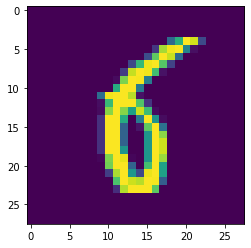

9


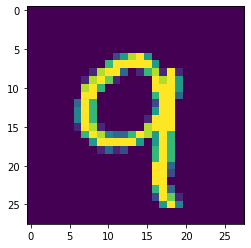

9


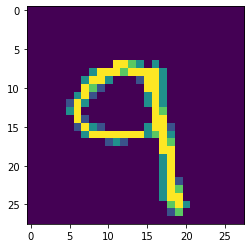

2


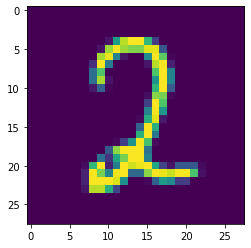

4


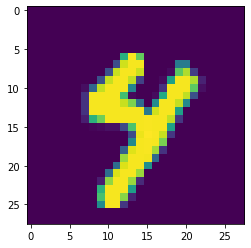

In [18]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()
show5(train_loader)

In [19]:
# Explore data
print("Training set:")
print("Number of samples:", len(train_set))
print("Shape of each train image:", train_set[0][0].shape)

print("\nTest set:")
print("Number of samples:", len(test_set))
print("Shape of each test image:", test_set[0][0].shape)

Training set:
Number of samples: 60000
Shape of each train image: torch.Size([1, 28, 28])

Test set:
Number of samples: 10000
Shape of each test image: torch.Size([1, 28, 28])


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [20]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.model(x)

model = NeuralNetwork()


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model and move it to the device
model = model.to(device)

num_epochs = 10
print_loss_every = 250

train_losses = []
valid_losses = []

num_batches = len(train_loader)

for epoch in range(num_epochs):
    model.train()  # Ensure model is in training mode
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if (batch_idx + 1) % print_loss_every == 0:
            average_loss = running_loss / print_loss_every
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{num_batches}], Loss: {average_loss:.2f}")
            running_loss = 0.0

    train_losses.append(average_loss)

    # Validation process
    model.eval()  # Ensure model is in evaluation mode
    valid_loss = 0.0
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_fn(output, target)
            valid_loss += loss.item()

    average_valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(average_valid_loss)
    print(f"Valid Epoch [{epoch+1}/{num_epochs}], Loss: {average_valid_loss:.2f}")


Epoch [1/10], Batch [250/844], Loss: 0.48
Epoch [1/10], Batch [500/844], Loss: 0.22
Epoch [1/10], Batch [750/844], Loss: 0.17
Valid Epoch [1/10], Loss: 0.16
Epoch [2/10], Batch [250/844], Loss: 0.13
Epoch [2/10], Batch [500/844], Loss: 0.12
Epoch [2/10], Batch [750/844], Loss: 0.11
Valid Epoch [2/10], Loss: 0.11
Epoch [3/10], Batch [250/844], Loss: 0.08
Epoch [3/10], Batch [500/844], Loss: 0.08
Epoch [3/10], Batch [750/844], Loss: 0.08
Valid Epoch [3/10], Loss: 0.09
Epoch [4/10], Batch [250/844], Loss: 0.06
Epoch [4/10], Batch [500/844], Loss: 0.06
Epoch [4/10], Batch [750/844], Loss: 0.07
Valid Epoch [4/10], Loss: 0.08
Epoch [5/10], Batch [250/844], Loss: 0.04
Epoch [5/10], Batch [500/844], Loss: 0.05
Epoch [5/10], Batch [750/844], Loss: 0.05
Valid Epoch [5/10], Loss: 0.08
Epoch [6/10], Batch [250/844], Loss: 0.04
Epoch [6/10], Batch [500/844], Loss: 0.04
Epoch [6/10], Batch [750/844], Loss: 0.05
Valid Epoch [6/10], Loss: 0.09
Epoch [7/10], Batch [250/844], Loss: 0.03
Epoch [7/10], Ba

Plot the training loss (and validation loss/accuracy, if recorded).

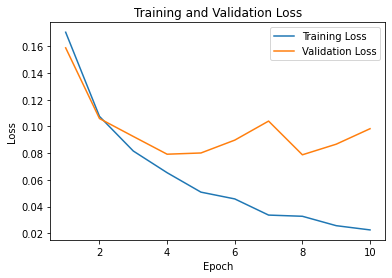

In [28]:
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [29]:
# Ensure model is in evaluation mode
model.eval()

correct = 0
total = 0

# Disable gradient calculation
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        
        # Get predictions and update counts
        predicted = torch.argmax(output, dim=1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 97.77%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [30]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

model = NeuralNetwork()
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model and move it to the device
model = model.to(device)

num_epochs = 10
print_loss_every = 250

train_losses = []
valid_losses = []

num_batches = len(train_loader)

for epoch in range(num_epochs):
    model.train()  # Ensure model is in training mode
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if (batch_idx + 1) % print_loss_every == 0:
            average_loss = running_loss / print_loss_every
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{num_batches}], Loss: {average_loss:.2f}")
            running_loss = 0.0

    train_losses.append(average_loss)

    # Validation process
    model.eval()  # Ensure model is in evaluation mode
    valid_loss = 0.0
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_fn(output, target)
            valid_loss += loss.item()

    average_valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(average_valid_loss)
    print(f"Valid Epoch [{epoch+1}/{num_epochs}], Loss: {average_valid_loss:.2f}")

Epoch [1/10], Batch [250/844], Loss: 1.19
Epoch [1/10], Batch [500/844], Loss: 1.20
Epoch [1/10], Batch [750/844], Loss: 1.17
Valid Epoch [1/10], Loss: 0.08
Epoch [2/10], Batch [250/844], Loss: 1.17
Epoch [2/10], Batch [500/844], Loss: 1.18
Epoch [2/10], Batch [750/844], Loss: 1.18
Valid Epoch [2/10], Loss: 0.06
Epoch [3/10], Batch [250/844], Loss: 1.16
Epoch [3/10], Batch [500/844], Loss: 1.16
Epoch [3/10], Batch [750/844], Loss: 1.18
Valid Epoch [3/10], Loss: 0.05
Epoch [4/10], Batch [250/844], Loss: 1.18
Epoch [4/10], Batch [500/844], Loss: 1.15
Epoch [4/10], Batch [750/844], Loss: 1.17
Valid Epoch [4/10], Loss: 0.04
Epoch [5/10], Batch [250/844], Loss: 1.16
Epoch [5/10], Batch [500/844], Loss: 1.16
Epoch [5/10], Batch [750/844], Loss: 1.17
Valid Epoch [5/10], Loss: 0.06
Epoch [6/10], Batch [250/844], Loss: 1.15
Epoch [6/10], Batch [500/844], Loss: 1.17
Epoch [6/10], Batch [750/844], Loss: 1.16
Valid Epoch [6/10], Loss: 0.04
Epoch [7/10], Batch [250/844], Loss: 1.15
Epoch [7/10], Ba

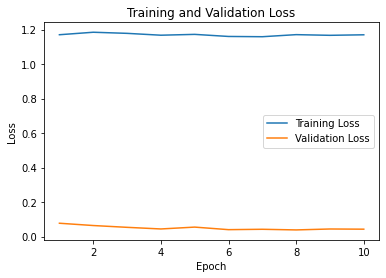

In [34]:
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [35]:
# Ensure model is in evaluation mode
model.eval()

correct = 0
total = 0

# Disable gradient calculation
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        
        # Get predictions and update counts
        predicted = torch.argmax(output, dim=1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 99.12%


## Saving your model
Using `torch.save`, save your model for future loading.

In [38]:
# Define the path to save the model
MODEL_PATH = './saved_model'

# Save the model
torch.save(model.state_dict(), MODEL_PATH)

print("Model saved successfully!")

Model saved successfully!
